# Training and Testing
After data preprocessing, I aim to develop a 2 layer LSTM architecture which takes in a sequence of 30 cycles to predict the RUL of the engine. The whole process includes various steps :
- The first step is of course, is to define the input to be fed. We will be feeding a 3D matrix to this network. We can visualize it by imagining a 30 x 14 dimension planes stacked over one another.
- After the input matrix has been made then decide the loss function and the number of units in each layer. This is done by hyperparameter tuning. Note that, here we have used a custom asymmetric function to penalize late predictions more. Along with our custom loss function we are also keeping track of the loss function suggested by NASA and MSE.
- The reason of not using NASA's suggested loss function is the fact that it contains exponential terms, and hence will cause exploding gradients.
- After hyperparameter tuning model, we train and test the data

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Creation of Input Matrix

In [6]:
def create_lstm_dataset(df, seq_length, feature_cols, target_cols = 'RUL'):
  X_seq = []
  Y_seq = []

  for engine_id in df['unit_nr'].unique() :
    engine_data = df[df['unit_nr'] == engine_id]
    engine_array = engine_data[feature_cols].values #2d matrix
    engine_rul = engine_data[target_cols].values
    num_rows = engine_array.shape[0]
    if num_rows < seq_length :
      print('Enough data not available')
      continue

    for i in range(num_rows - seq_length + 1):
      window = engine_array[i : i+seq_length]
      target = engine_rul[i + seq_length -1]
      X_seq.append(window)
      Y_seq.append(target)

  return np.array(X_seq), np.array(Y_seq)

In [7]:
# Sliding Window to define output and input
train_df = pd.read_csv('final_train_FD001.csv')
feature_cols = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21' ]
sequence_length = 30
X_train, Y_train = create_lstm_dataset(train_df, sequence_length, feature_cols)
print(X_train.shape)
print(Y_train.shape)


(17731, 30, 14)
(17731,)


# Defining Losses and LSTM

In [13]:
# Custom loss function to penalize late predictions more
def NASA_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  d = y_pred - y_true
  score_early = tf.math.exp(-d / 13.0) - 1
  score_late = tf.math.exp(d / 10.0) - 1
  loss_vector = tf.where(d < 0, score_early, score_late)
  return K.mean(loss_vector)

def safe_loss(alpha):
  def _safe_loss(y_true, y_pred):
    err = y_pred - y_true
    alpha_f = tf.cast(alpha, tf.float32)
    penalty_weight = tf.where(err > 0, alpha_f, 1.0)
    return K.mean(penalty_weight * K.square(err))
  return _safe_loss

# Building LSTM
def build_lstm_model(input_shape, layer1_units, layer2_units, dropout_rate, alpha) :
  model = Sequential()
  #  Layer 1 :
  model.add(LSTM(units = layer1_units, input_shape = input_shape, return_sequences = True))
  model.add(Dropout(dropout_rate))

  # Layer 2 :
  model.add(LSTM(units = layer2_units, return_sequences = False))
  model.add(Dropout(dropout_rate))

  # Output Layer : Regression
  model.add(Dense(units = 1, activation = 'linear'))

  model.compile(optimizer = 'adam', loss= safe_loss(alpha = alpha), metrics=['mse', NASA_loss])

  return model

# Hyperparameter Tuning

In [23]:
input_shape = (X_train.shape[1], X_train.shape[2]) #(30,14)
# layer1_options = [50, 100, 150]
# layer2_options = [64, 128, 256]
layer1_options = [50,100,150]
layer2_options = [32,64,128,256,512]
alpha_options= [2,5,10,20,40,60,80,100]

best_loss = float('inf')
best_config = (100, 50,20) # Default placeholder

print(f"Starting Grid Search on {len(layer1_options) * len(layer2_options) * len(alpha_options)} combinations...")
print("=" * 60)

for u1 in layer1_options:
    for u2 in layer2_options:
      for alpha in alpha_options:
        print(f"Testing: Layer1={u1} -> Layer2={u2} ... -> Alpha = {alpha}", end="")
        model = build_lstm_model(input_shape, u1, u2, 0.2, alpha)
        history = model.fit(X_train, Y_train, epochs=5, batch_size=200, validation_split=0.2, verbose=1)
        val_loss = history.history['val_loss'][-1]
        val_mse_loss = history.history['val_mse'][-1]
        val_NASA_loss = history.history['val_nasa_loss'][-1]
        print(f"Val asymm loss: {val_loss:.4f}")
        print(f"Val NASA loss : {val_NASA_loss:.4f}")
        print(f"Val mse loss : {val_mse_loss:.4f}")


        if val_loss < best_loss:
            best_loss = val_loss
            best_config = (u1, u2, alpha)


print(f" Final structure : Layer 1 = {best_config[0]}, Layer 2 = {best_config[1]}, alpha = {best_config[2]}")


Starting Grid Search on 120 combinations...
Testing: Layer1=50 -> Layer2=32 ... Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7556.8423 - mse: 7556.6289 - nasa_loss: 4219.5483 - val_loss: 7500.1777 - val_mse: 7498.8696 - val_nasa_loss: 3272.3518
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6754.6226 - mse: 6752.7393 - nasa_loss: 2636.2852 - val_loss: 7094.8447 - val_mse: 7091.9429 - val_nasa_loss: 2650.4014
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6306.7412 - mse: 6303.0522 - nasa_loss: 2113.2410 - val_loss: 6750.5112 - val_mse: 6745.4282 - val_nasa_loss: 2200.6248
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6118.9497 - mse: 6113.0293 - nasa_loss: 1825.6581 - val_loss: 6417.1704 - val_mse: 6408.9980 - val_nasa_loss: 1825.5278
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5790.0693 - mse: 5780.3667 - nasa_loss: 1506.7744 - val_loss: 6110.4966 - val_mse: 6098.3936 - val_nasa_loss: 1526.8730
Val asymm loss: 6110.4966
Val NASA loss : 1526.8730
Val mse loss : 6098.3936
Testing: Layer1=50 -> Layer2=32 ... Epoch 1/5
7

# Training

In [24]:
# Final model :
input_shape = (X_train.shape[1], X_train.shape[2]) #(30,14)
final_model = build_lstm_model(input_shape, 50, 512, 0.2,10)
history = final_model.fit(X_train, Y_train,
                          epochs=50,
                          batch_size=200,
                          validation_split=0.2,
                          verbose=1)
val_loss = history.history['val_loss'][-1]
val_mse_loss = history.history['val_mse'][-1]
val_NASA_loss = history.history['val_nasa_loss'][-1]
print(f"Val asymm loss: {val_loss:.4f}")
print(f"Val NASA loss : {val_NASA_loss:.4f}")
print(f"Val mse loss : {val_mse_loss:.4f}")



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 5471.0063 - mse: 5052.9619 - nasa_loss: 1513.5620 - val_loss: 4794.9907 - val_mse: 3732.4895 - val_nasa_loss: 293.7140
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4459.3027 - mse: 3357.1223 - nasa_loss: 259.5288 - val_loss: 4772.7002 - val_mse: 3759.8271 - val_nasa_loss: 302.6439
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4410.5142 - mse: 3339.4907 - nasa_loss: 255.8322 - val_loss: 4806.3994 - val_mse: 3841.0161 - val_nasa_loss: 322.2829
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4349.3491 - mse: 3345.3755 - nasa_loss: 266.4879 - val_loss: 4045.1814 - val_mse: 3324.0308 - val_nasa_loss: 269.7126
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2835.5513 - mse: 2432.4260 - nasa_loss: 387.3929 - val_loss: 1668.8586 - val_mse: 1617.0841 - val_nasa_loss: 490.1034
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1059.0222 - mse: 866.6215 - nasa_loss: 611.4828 - val_l

# Defining Test Data

In [25]:
def process_test_data (rul_df, test_df, sequence_length = 30) :
  engine_id = test_df['unit_nr'].unique()
  X_test = []
  Y_test = []

  for engine in engine_id :
    engine_data = test_df[test_df['unit_nr'] == engine]
    if len(engine_data) >= sequence_length :
      window = engine_data[feature_cols].values[-sequence_length :]
      current_engine_rul = rul_df.iloc[engine - 1]['RUL']
      Y_test.append(current_engine_rul)
      X_test.append(window)
    else :
      print('ENOUGH DATA NOT AVAILABLE')


  return np.array(X_test), np.array(Y_test)

In [26]:
sequence_length = 30
test_df = pd.read_csv('final_test_FD001.csv')
rul_df = pd.read_csv('RUL_FD001.csv')
X_test, Y_test = process_test_data(rul_df, test_df, sequence_length)
print(f"Final Test Input Shape: {X_test.shape}")
print(f"Final Test Label Shape: {Y_test.shape}")

Final Test Input Shape: (100, 30, 14)
Final Test Label Shape: (100,)


# Testing

In [27]:
y_pred_test = model.predict(X_test)
y_true = Y_test.flatten()
y_pred = y_pred_test.flatten()
test_mse = mean_squared_error(y_true, y_pred)
test_NASA = NASA_loss(y_true, y_pred)
print(f"MSE Accuracy   : {test_mse:.2f}")
print(f"NASA Safety    : {test_NASA:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
MSE Accuracy   : 1336.71
NASA Safety    : 38.64


# Final Plots for Testing Data :

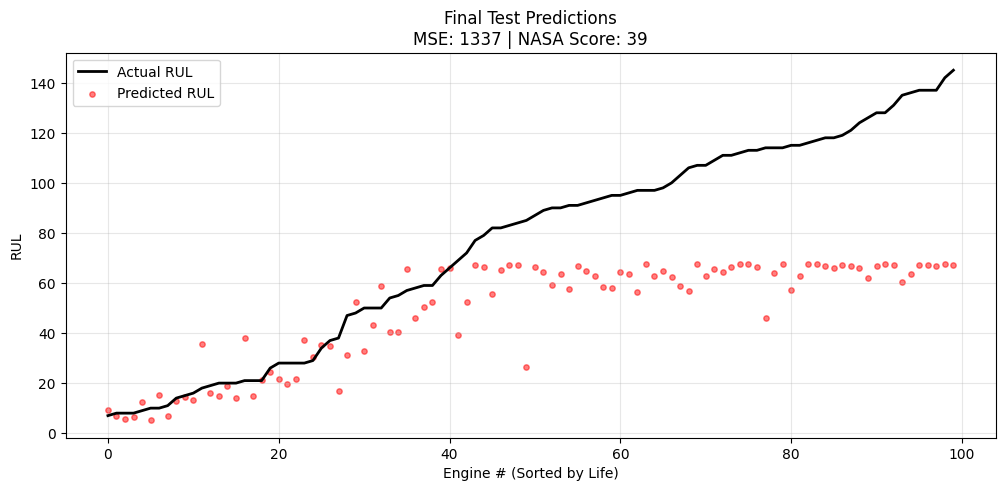

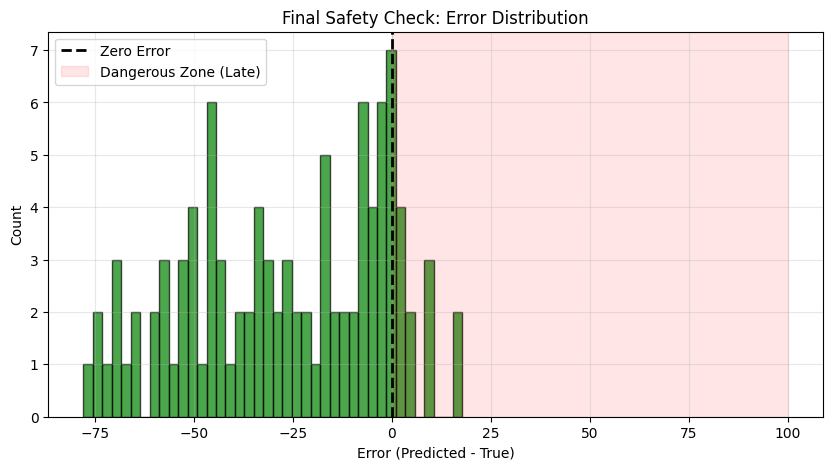

In [28]:
# Plot 1: Prediction Alignment
plt.figure(figsize=(12, 5))
sorted_indices = np.argsort(y_true)
plt.plot(y_true[sorted_indices], color='black', linewidth=2, label='Actual RUL')
plt.scatter(np.arange(len(y_pred)), y_pred[sorted_indices], color='red', s=15, alpha=0.5, label='Predicted RUL')
plt.title(f'Final Test Predictions\nMSE: {test_mse:.0f} | NASA Score: {test_NASA:.0f}')
plt.xlabel('Engine # (Sorted by Life)')
plt.ylabel('RUL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: Safety Histogram
errors = y_pred - y_true
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=40, color='green', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')
plt.axvspan(0, 100, color='red', alpha=0.1, label='Dangerous Zone (Late)')
plt.title('Final Safety Check: Error Distribution')
plt.xlabel('Error (Predicted - True)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()